This notebook presents an implementation of XGBoost Classifier in the finance industry, specifically in credit card fraud detection. After building the XGBoost Classifier it will use the HyperOpt Library, an alternative to sklearn's GridSearchCV and RandomziedSearchCV algorithms, to tune the various model parameters with the goal of achieving the maximum f1-score for the classification of normal and fraud transactions. As part of the model evaluation, the f1-score metric will be computed, a confusion matrix will be constructed for the classification, a classification report will be generated and a Precision-Recall Curve plotted. Finally, feature importances will be computed and plotted based on both XGBoost's internal algorithm, as well as the SHAP implementation of feature importances. 

***Note that exploratory data analysis is not the focus of this notebook, so it will be only done briefly.

### Loading Libraries and Data

In [64]:
#loading libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import xgboost as xgb
import shap
# Any results you write to the current directory are saved as output.

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
#loading the data into a dataframe
credit_df = pd.read_csv('./creditcard.csv')

### Data Overview

In [3]:
#preview of the first 10 rows of data
credit_df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [4]:
#displaying descriptive statistics
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
#exploring datatypes and count of non-NULL rows for each feature
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

### Data Preparation

Here we look for and remove duplicated observations in our data, define our independent (X) and dependent (Y) variables for classification, and separate out both the validation and test sets.

In [8]:
#checking for duplicated observations
credit_df.duplicated().value_counts()

False    283726
True       1081
dtype: int64

In [9]:
#dropping duplicated observations
credit_df = credit_df.drop_duplicates()

In [10]:
#defining independent (X) and dependent (Y) variables from dataframe
X = credit_df.drop(columns = 'Class')
Y = credit_df['Class'].values

In [11]:
#splitting a testing set from the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, stratify = Y, random_state = 42)
#splitting a validation set from the training set to tune parameters
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.20, stratify = Y_train, random_state = 42)

### Model Set-Up and Training

In this section, we create a scorer based on the f1-metric and define the parameter search space for our XGBoost model. Addtionally, we define a function that encompasses our classifier, extracts its predictions, calculates loss and feeds it to the optimizer. Finally, we initialize the optimizer with the desired settings, run it and look at the parameters and scores over the trials.

In [12]:
#creating a scorer from the f1-score metric
f1_scorer = make_scorer(f1_score)

In [13]:
# defining the space for hyperparameter tuning
space = {'eta': hp.uniform("eta", 0.1, 1),
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 50, 200, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 200, 10)
        }

In [14]:
#defining function to optimize
def hyperparameter_tuning(space):
    clf = xgb.XGBClassifier(n_estimators = int(space['n_estimators']),       #number of trees to use
                            eta = space['eta'],                              #learning rate
                            max_depth = int(space['max_depth']),             #depth of trees
                            gamma = space['gamma'],                          #loss reduction required to further partition tree
                            reg_alpha = int(space['reg_alpha']),             #L1 regularization for weights
                            reg_lambda = space['reg_lambda'],                #L2 regularization for weights
                            min_child_weight = space['min_child_weight'],    #minimum sum of instance weight needed in child
                            colsample_bytree = space['colsample_bytree'],    #ratio of column sampling for each tree
                            nthread = -1)                                    #number of parallel threads used
    
    evaluation = [(X_train, Y_train), (X_val, Y_val)]
    
    clf.fit(X_train, Y_train,
            eval_set = evaluation,
            early_stopping_rounds = 10,
            verbose = False)

    pred = clf.predict(X_val)
    pred = [1 if i>= 0.5 else 0 for i in pred]
    f1 = f1_score(Y_val, pred)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [15]:
# run the hyper paramter tuning
trials = Trials()
best = fmin(fn = hyperparameter_tuning,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

print (best)

SCORE:                                                 
0.7552447552447553                                     
SCORE:                                                                            
0.0                                                                               
SCORE:                                                                            
0.0                                                                               
SCORE:                                                                            
0.0                                                                               
SCORE:                                                                            
0.0                                                                               
SCORE:                                                                            
0.0                                                                               
SCORE:                                                    

0.7499999999999999                                                                 
SCORE:                                                                             
0.8169014084507042                                                                 
SCORE:                                                                             
0.7910447761194029                                                                 
100%|██████████| 100/100 [11:24<00:00,  6.84s/trial, best loss: -0.8201438848920864]
{'colsample_bytree': 0.9999995803500363, 'eta': 0.1316102455832729, 'gamma': 1.6313395777817137, 'max_depth': 5.0, 'min_child_weight': 3.0, 'n_estimators': 100.0, 'reg_alpha': 47.0, 'reg_lambda': 0.4901343161108276}


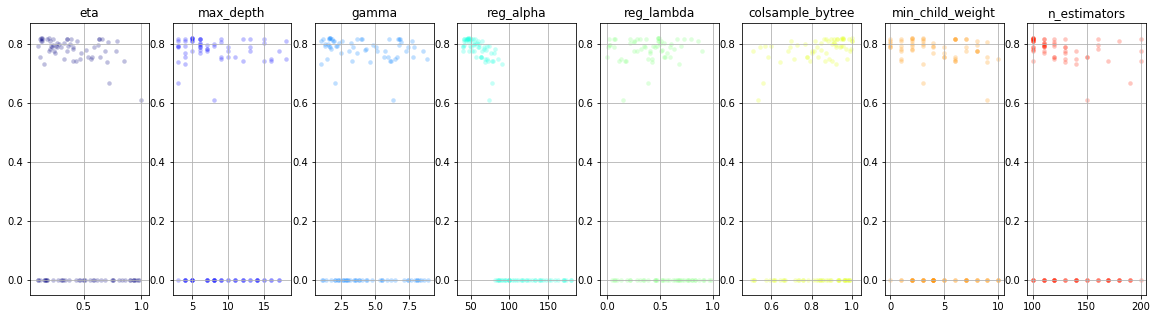

In [16]:
#plotting feature space and f1-scores for the different trials
parameters = space.keys()
cols = len(parameters)

f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.25, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    axes[i].grid()

In [17]:
#printing best model parameters
print(best)

{'colsample_bytree': 0.9999995803500363, 'eta': 0.1316102455832729, 'gamma': 1.6313395777817137, 'max_depth': 5.0, 'min_child_weight': 3.0, 'n_estimators': 100.0, 'reg_alpha': 47.0, 'reg_lambda': 0.4901343161108276}


### Model Test and Evaluation

This section will explore and visualize how the model performs on the test data.

In [18]:
#initializing XGBoost Classifier with best model parameters
best_clf = xgb.XGBClassifier(n_estimators = int(best['n_estimators']), 
                            eta = best['eta'], 
                            max_depth = int(best['max_depth']), 
                            gamma = best['gamma'], 
                            reg_alpha = int(best['reg_alpha']), 
                            min_child_weight = best['min_child_weight'], 
                            colsample_bytree = best['colsample_bytree'], 
                            nthread = -1)

In [19]:
#fitting XGBoost Classifier with best model parameters to training data
best_clf.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9999995803500363,
              eta=0.1316102455832729, gamma=1.6313395777817137,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=47, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
#using the model to predict on the test set
Y_pred = best_clf.predict(X_test)

In [56]:
#printing f1 score of test set predictions
print('The f1-score on the test data is: {0:.2f}'.format(f1_score(Y_test, Y_pred)))

The f1-score on the test data is: 0.74


In [27]:
#creating a confusion matrix and labels
cm = confusion_matrix(Y_test, Y_pred)
labels = ['Normal', 'Fraud']

Text(0.5, 1.0, 'Confusion Matrix for Credit Card Fraud Detection')

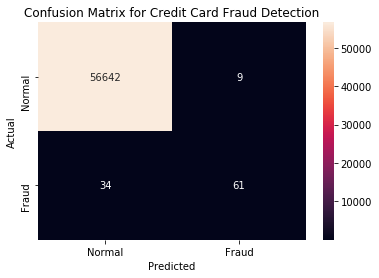

In [28]:
#plotting the confusion matrix
sns.heatmap(cm, annot = True, xticklabels = labels, yticklabels = labels, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Credit Card Fraud Detection')

In [60]:
#printing classification report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.87      0.64      0.74        95

    accuracy                           1.00     56746
   macro avg       0.94      0.82      0.87     56746
weighted avg       1.00      1.00      1.00     56746



Text(0.5, 1.0, 'Precision-Recall Curve: AP=0.74')

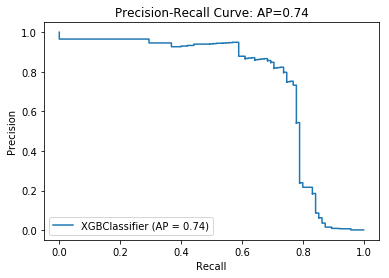

In [73]:
Y_score = best_clf.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(Y_test, Y_score)
fig = plot_precision_recall_curve(best_clf, X_test, Y_test)
fig.ax_.set_title('Precision-Recall Curve: AP={0:.2f}'.format(average_precision))

### Feature Importances

This section will look at two algorithms, one in XGBoost and one in SHAP, that visualize feature importances. Unfortunately, since the features of this dataset are encoded using Principal Component Analysis (PCA), we cannot draw on intuition to draw conclusions as to how the model predicted normal and fraud transactions from a practical standpoint.

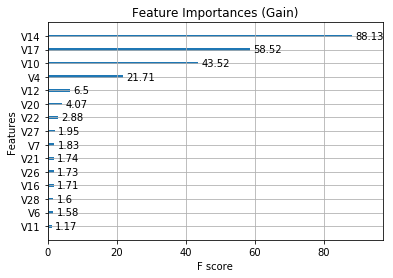

In [43]:
#extracting the booster from model
booster = best_clf.get_booster()

# scoring features based on information gain
importance = booster.get_score(importance_type = "gain")

#rounding importances to 2 decimal places
for key in importance.keys():
    importance[key] = round(importance[key],2)

# plotting feature importances
ax = xgb.plot_importance(importance, importance_type='gain', show_values=True)
plt.title('Feature Importances (Gain)')
plt.show()

In [51]:
#obtaining SHAP values for XGBoost Model
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_train)

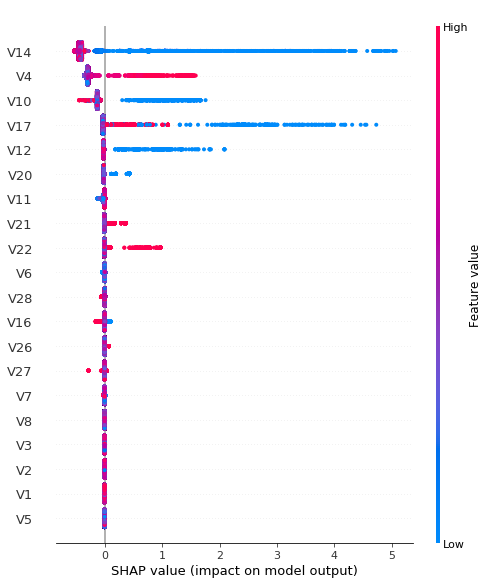

In [55]:
#plotting SHAP Values of Feature Importances
shap.summary_plot(shap_values, X_train)